In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

1. Augmentation 을 적용한 데이터셋 만들기 

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
(ds_train,ds_test),ds_info = tfds.load(
    'stanford_dogs',
    split=['train','test'],
    shuffle_files=True,
    with_info=True,
)

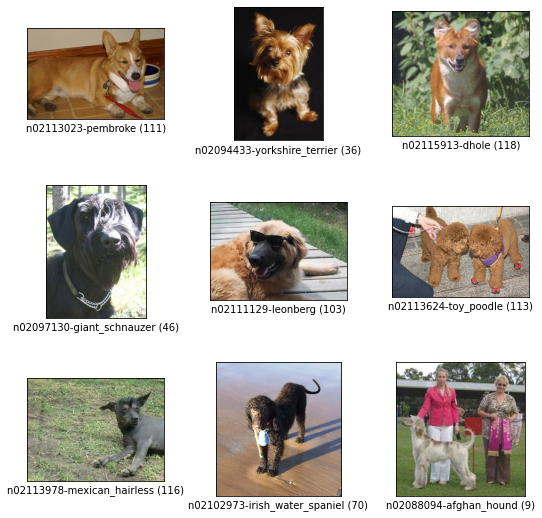

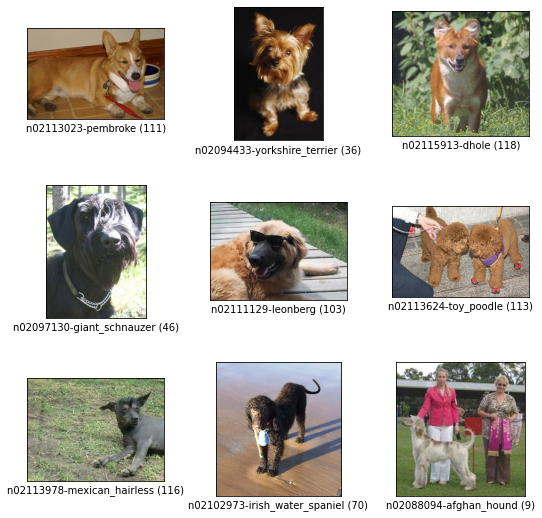

In [ ]:
tfds.show_examples(ds_train,ds_info)

1. augmentation 전에 data 를 전처리 하는 함수 
- image 를 원하는 사이즈로 resize 하고 normalize 해주는 함수

In [ ]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

- 기본 augmentation 적용 함수 
  - random 하게 좌우 반전을 주어 데이터를 늘려준다
  - random 하게 밝기를 조절해준다

In [ ]:
def augment(image,label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_brightness(image,max_delta=0.2)
  image = tf.clip_by_value(image,0,1)
  return image, label

### 2. CutMix augmentation 사용하기

- 이미지 데이터를 자르고 섞는다
- Cutout 으로 이미지를 자르고 자른 이미지를 mix 하는 것 
- 이미지를 섞는 부분과 섞은 이미지에 맞추어 라벨도 섞어줘야함 

1. 두가지 이미지중 바탕 이미지 A 에 삽일될 영역의 바운딩 박스 위치를 결정하는 함수

In [ ]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

2. 바탕 이미지에서 바운딩 박스 바깥쪽 영역을 다른이미지에서 바운딩 박스 안쪽 영역을 가져와 합치는 함수

In [ ]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img


3. 이미지를 섞은 비율에 맞게 라벨도 섞어주는 함수 

In [ ]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, image_size=224,num_classes=120):
    # image_size_x = image_a.shape[1]
    # image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size*image_size
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label


4. 배치단위의 cutmix 함수

In [ ]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels


### 3. Mixup Augmentation

- 두가지 이미지와 라벨을 블렌딩 해준다 
- 두 개 이미지의 픽셀별 값을 비율에 따라 섞어주는 방식
- 두 이미지 쌍을 섞은 비율을 일정 범위 내에서 랜덤하게 뽑고, 해당 비율 값에 따라 두 이미지의 픽셀별 값과 라벨을 섞어준다

In [ ]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [ ]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### 4. Onehot 

- cutmix 와 mixup 을 사용할 경우 test 이미지에 onehot 을 적용하여 비교하여야 한다

In [ ]:
def onehot(image,label,batch_size=16,img_size=224,num_classes=120):
  onehot_imgs = []
  onehot_labels = []

  for i in range(batch_size):
    image_a = image[i]
    label_a = label[i]
    if len(label_a.shape)==0:
      label_a = tf.one_hot(label_a,num_classes)

    onehot_imgs.append(image_a)
    onehot_labels.append(label_a)

  onehot_imgs = tf.reshape(tf.stack(onehot_imgs), (batch_size, img_size, img_size, 3))
  onehot_labels = tf.reshape(tf.stack(onehot_labels), (batch_size, num_classes))
  return onehot_imgs,onehot_labels
  # 근데 이거 왜쓰는거임 ? 어짜피사용 안할거 아닌가....?

### 5. dataset 에 augmentation 적용하기

In [ ]:
def apply_normalize_on_dataset(ds,is_test=False,batch_size=16,
                                with_aug=False,with_cutmix=False,with_mixup=False,with_onehot=False):
  ds = ds.map(
      normalize_and_resize_img,
      num_parallel_calls=2
  )
  if not is_test and with_aug:
    ds = ds.map(
        augment
    )
  ds = ds.batch(batch_size)
  if not is_test and with_cutmix:
    ds = ds.map(
        cutmix,
        num_parallel_calls=2
    )
  elif not is_test and with_mixup:
    ds = ds.map(
        mixup,
        num_parallel_calls=2
    )
  else :
    ds = ds.map(
        onehot,
        num_parallel_calls=2
    )
  if not is_test:
    ds = ds.repeat()
    ds = ds.shuffle(200)
  ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
  return ds


In [ ]:
num_classes = ds_info.features['label'].num_classes
print(num_classes)

120


6. Model 불러오기
- keras 에 들어있는 resnet 50 을 가져와서 사용 

In [ ]:
num_classes = ds_info.features['label'].num_classes
resnet50 = keras.models.Sequential([
                                    keras.applications.resnet.ResNet50(
                                        include_top=False,
                                        weights='imagenet',
                                        input_shape=(224,224,3),
                                        pooling='avg',
                                    ),
                                    keras.layers.Dense(num_classes,activation='softmax')
])

In [ ]:
(ds_train, ds_test),ds_info=tfds.load(
    'stanford_dogs',
    split=['train','test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,)

ds_train_no_aug = apply_normalize_on_dataset(ds_train,with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train,with_aug=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train,with_aug=True,with_mixup=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train,with_aug=True,with_cutmix=True)

ds_test = apply_normalize_on_dataset(ds_test, is_test=True)
# ds_test_onehot = apply_normalize_on_dataset(ds_test, is_test=True,with_onehot=True)

7. 학습하기

In [ ]:
EPOCH = 20

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 112s 126ms/step - loss: 2.1890 - accuracy: 0.4502 - val_loss: 3.0700 - val_accuracy: 0.2479
Epoch 2/20
750/750 [==============================] - 95s 127ms/step - loss: 0.6839 - accuracy: 0.8143 - val_loss: 1.1547 - val_accuracy: 0.6643
Epoch 3/20
750/750 [==============================] - 93s 124ms/step - loss: 0.2116 - accuracy: 0.9592 - val_loss: 0.9632 - val_accuracy: 0.7169
Epoch 4/20
750/750 [==============================] - 100s 133ms/step - loss: 0.1126 - accuracy: 0.9854 - val_loss: 0.9348 - val_accuracy: 0.7340
Epoch 5/20
750/750 [==============================] - 94s 126ms/step - loss: 0.0496 - accuracy: 0.9959 - val_loss: 0.9493 - val_accuracy: 0.7381
Epoch 6/20
750/750 [==============================] - 93s 125ms/step - loss: 0.0193 - accuracy: 0.9987 - val_loss: 0.9233 - val_accuracy: 0.7474
Epoch 7/20
750/750 [==============================] - 93s 124ms/step - loss: 0.0100 - accuracy: 0.9998 - val_loss: 0.9263 - val_

In [ ]:
history_resnet50_aug = resnet50.fit(
    ds_train_aug, # augment 만 적용 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 98s 124ms/step - loss: 0.3760 - accuracy: 0.8903 - val_loss: 2.2549 - val_accuracy: 0.4609
Epoch 2/20
750/750 [==============================] - 93s 124ms/step - loss: 0.2730 - accuracy: 0.9258 - val_loss: 1.4726 - val_accuracy: 0.6109
Epoch 3/20
750/750 [==============================] - 95s 126ms/step - loss: 0.1353 - accuracy: 0.9668 - val_loss: 1.1619 - val_accuracy: 0.7000
Epoch 4/20
750/750 [==============================] - 93s 124ms/step - loss: 0.0707 - accuracy: 0.9859 - val_loss: 1.0995 - val_accuracy: 0.7083
Epoch 5/20
750/750 [==============================] - 93s 124ms/step - loss: 0.0368 - accuracy: 0.9937 - val_loss: 1.0642 - val_accuracy: 0.7338
Epoch 6/20
750/750 [==============================] - 93s 124ms/step - loss: 0.0271 - accuracy: 0.9957 - val_loss: 1.0406 - val_accuracy: 0.7417
Epoch 7/20
750/750 [==============================] - 93s 125ms/step - loss: 0.0253 - accuracy: 0.9965 - val_loss: 1.1582 - val_ac

In [ ]:
history_resnet50_cutmix = resnet50.fit(
    ds_train_cutmix, # cutmix 적용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 101s 126ms/step - loss: 2.4200 - accuracy: 0.6439 - val_loss: 1.4823 - val_accuracy: 0.6150
Epoch 2/20
750/750 [==============================] - 95s 126ms/step - loss: 2.2653 - accuracy: 0.6672 - val_loss: 1.3848 - val_accuracy: 0.6435
Epoch 3/20
750/750 [==============================] - 93s 124ms/step - loss: 2.1465 - accuracy: 0.6996 - val_loss: 1.6020 - val_accuracy: 0.5893
Epoch 4/20
750/750 [==============================] - 93s 124ms/step - loss: 2.0820 - accuracy: 0.7154 - val_loss: 1.2676 - val_accuracy: 0.6713
Epoch 5/20
750/750 [==============================] - 93s 123ms/step - loss: 2.0259 - accuracy: 0.7300 - val_loss: 1.4610 - val_accuracy: 0.6284
Epoch 6/20
750/750 [==============================] - 95s 126ms/step - loss: 1.9756 - accuracy: 0.7436 - val_loss: 1.2997 - val_accuracy: 0.6650
Epoch 7/20
750/750 [==============================] - 95s 126ms/step - loss: 1.9342 - accuracy: 0.7466 - val_loss: 1.3409 - val_a

In [ ]:
history_resnet50_mixup = resnet50.fit(
    ds_train_mixup, # mixup 적용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 100s 125ms/step - loss: 1.9053 - accuracy: 0.8247 - val_loss: 1.6134 - val_accuracy: 0.6341
Epoch 2/20
750/750 [==============================] - 95s 127ms/step - loss: 1.8593 - accuracy: 0.8348 - val_loss: 1.8403 - val_accuracy: 0.5763
Epoch 3/20
750/750 [==============================] - 117s 156ms/step - loss: 1.8357 - accuracy: 0.8399 - val_loss: 1.3963 - val_accuracy: 0.6835
Epoch 4/20
750/750 [==============================] - 100s 133ms/step - loss: 1.8245 - accuracy: 0.8443 - val_loss: 1.5630 - val_accuracy: 0.6318
Epoch 5/20
750/750 [==============================] - 97s 129ms/step - loss: 1.7933 - accuracy: 0.8422 - val_loss: 1.3106 - val_accuracy: 0.6969
Epoch 6/20
750/750 [==============================] - 95s 126ms/step - loss: 1.7775 - accuracy: 0.8543 - val_loss: 1.4218 - val_accuracy: 0.6718
Epoch 7/20
750/750 [==============================] - 116s 155ms/step - loss: 1.7458 - accuracy: 0.8553 - val_loss: 1.2887 - va

8. 시각화

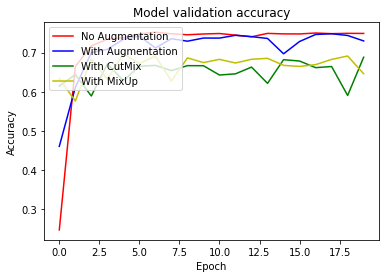

In [ ]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation','With CutMix','With MixUp'], loc='upper left')

plt.show()


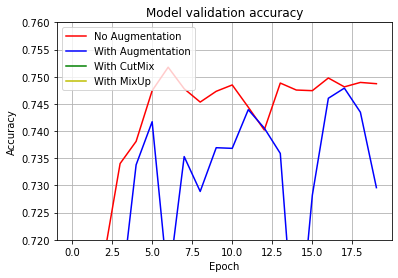

In [ ]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation','With CutMix','With MixUp'], loc='upper left')
plt.grid(True)
plt.ylim(0.72,0.76)

plt.show()


생각보다 cutmix 나 mixup augmentation 을 사용한 모델의 acuracy 가 높게 나오지는 않았다
- 1. augmentation 이라는 것 자체가 데이터를 다양하게 사용하려는 것 인데 original 을 그대로 사용하면서 augmentation 된 데이터를 추가한 것이 아니라, augmentation 이 된 모델만을 사용해서 실질적으로는 학습에 도움이 되지 않은게 아닐까
- 2. cutmix 나 mixup 자체가 개인적인 의견으로 멀쩡한 개 사진을 오히려 더 혼란스럽게 보이게 만드는 것 같은데 어떻게...도움이 된다는건지 잘 모르겠다